#apillay HW3P2 Notebook

Note: This notebook version corresponds to run v3090-tc460-pb2.2_resume+config_change+augment but with its config modified a bit (like reduced batch size) to run inference on my laptop's GPU. The code is however exactly the same as my final run listed below

WanDB link: https://wandb.ai/audio-idl/hw3p2-ablations?workspace=user-apillay
Please find the following runs used to track the training for this work:
1. v3090-tc100-pb2.2+embed_656: Trained from scratch on train-clean-100
2. v3090-tc460-pb2.2_resume-3.6: Trained from previous model's best checkpoint on train-clean-460
3. v3090-tc460-pb2.2_resume+config_change+augment: Trained from previous model's best checkpoint on increased data augmentation and lesser dropout/weight decay factors
4. v3090-tc460-pb2.2_resume2+config_change+augment: Trained from previous model's best checkpoint as the VM crashed
5. v3090-tc460-pb2.2_resume2_2.4+augmentations: Trained from previous model's best checkpoint with increased data augmentation factors
6. v3090-tc460-pb2.2_resume3_2.3: Trained from previous model's best checkpoint as I discovered my model had room to get a better score on Kaggle lol

Instructions to run the code:
Run all cells in the following sequence!

# Installs

### Levenshtein

This may take a while

In [ ]:
!pip install wandb --quiet
!pip install python-Levenshtein -q
!git clone --recursive https://github.com/parlance/ctcdecode.git
!pip install wget -q
%cd ctcdecode
!pip install . -q
%cd ..

!pip install --upgrade --force-reinstall torchsummaryX
!pip install pytorch-nlp
!pip install slugify
!pip install matplotlib
!pip install --upgrade --force-reinstall pandas
!pip install torchinfo

## Imports

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torchnlp.nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torchinfo import summary

import torchaudio.transforms as tat

import gc

import pandas as pd
from tqdm import tqdm
import os

# imports for decoding and distance calculation
import Levenshtein
from ctcdecode import CTCBeamDecoder

import warnings

warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [2]:
!nvidia-smi
!nvidia-smi -q -d POWER

Fri Apr  7 17:08:34 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 L...    Off| 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P3               N/A /  N/A|      8MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Kaggle Setup

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!rm -rf /root/.kaggle
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"ashwinpillay","key":"<api>"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c 11-785-s23-hw3p2

In [ ]:
!sudo apt-get install zip unzip

In [ ]:
'''
This will take a couple minutes, but you should see at least the following:
11-785-f22-hw3p2.zip  ctcdecode  hw3p2
'''
!unzip -q 11-785-s23-hw3p2.zip
!ls

# Config

In [42]:
config = {
    'batch_size': 8, # this is for my laptop GPU, user 64 for training on rtx3090
    'epochs': 500,
    'lr': 2e-3,
    'ctc_decoder_train': {
        'num_processes': 4,
        'beam_width': 8,
    },
    'ctc_decoder_test': {
        'num_processes': 4,
        'beam_width': 16,
    },
    'rlrop_params': {
        'factor': 0.75,
        'patience': 4,
        'threshold': 0.001,
        'threshold_mode': 'rel',
        'cooldown': 2,
    },
    'CA_lr_params': {
        'T_max': 8,
        'eta_min': 1e-6,
    },
    'dropout_p': 0.25,
    'adamw_weight_decay': 1e-2,
    'time_mask_maxl': 100,
    'time_mask_p': 0.9,
    'freq_mask_maxl': 5,
    'num_workers_train': 6,
    'num_workers_val': 2,
    'num_workers_test': 2,
}

# Dataset and Dataloader

In [4]:
# ARPABET PHONEME MAPPING
# DO NOT CHANGE
# This overwrites the phonetics.py file.

CMUdict_ARPAbet = {
    "": " ",
    "[SIL]": "-", "NG": "G", "F": "f", "M": "m", "AE": "@",
    "R": "r", "UW": "u", "N": "n", "IY": "i", "AW": "W",
    "V": "v", "UH": "U", "OW": "o", "AA": "a", "ER": "R",
    "HH": "h", "Z": "z", "K": "k", "CH": "C", "W": "w",
    "EY": "e", "ZH": "Z", "T": "t", "EH": "E", "Y": "y",
    "AH": "A", "B": "b", "P": "p", "TH": "T", "DH": "D",
    "AO": "c", "G": "g", "L": "l", "JH": "j", "OY": "O",
    "SH": "S", "D": "d", "AY": "Y", "S": "s", "IH": "I",
    "[SOS]": "[SOS]", "[EOS]": "[EOS]"
}

CMUdict = list(CMUdict_ARPAbet.keys())
ARPAbet = list(CMUdict_ARPAbet.values())

PHONEMES = CMUdict[:-2]
LABELS = ARPAbet[:-2]

### Train Data

In [5]:
def cepstral_normalize(mfcc):
    mean_mfcc = np.mean(mfcc, axis=0)
    std_mfcc = np.std(mfcc, axis=0) + np.finfo('float').eps
    normalized_mfcc = (mfcc - mean_mfcc) / std_mfcc
    return normalized_mfcc

In [6]:
# Utils for network
torch.cuda.empty_cache()


class PermuteBlock(torch.nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

In [7]:
class AudioDataset(torch.utils.data.Dataset):

    def __init__(self, root1='.', root2=None):
        '''
        Initializes the dataset.
        '''

        self.mfcc_paths, self.transcript_paths = [], []
        self.PHONEMES = PHONEMES

        self.augmentations = torch.nn.Sequential(
            PermuteBlock(),
            tat.TimeMasking(time_mask_param=config['time_mask_maxl'], p=config['time_mask_p']),
            tat.FrequencyMasking(freq_mask_param=config['freq_mask_maxl']),
            PermuteBlock(),
        )

        roots = [root1]
        if root2 is not None:
            roots.append(root2)

        for root in roots:
            print("=> Loading paths from: {}".format(root))
            mfcc_dir = os.path.join(root, 'mfcc')
            transcript_dir = os.path.join(root, 'transcript')

            mfcc_files = sorted(os.listdir(mfcc_dir))
            transcript_files = sorted(os.listdir(transcript_dir))

            root_file_length = len(mfcc_files)
            for i in tqdm(range(root_file_length)):
                self.mfcc_paths.append(os.path.join(root, 'mfcc', mfcc_files[i]))
                self.transcript_paths.append(os.path.join(root, 'transcript', transcript_files[i]))
        # Train Dataset only initializes with path to reduce CPU RAM usage (empirically found that fetching data during __getitem__ is not too costly!

        assert len(self.mfcc_paths) == len(self.transcript_paths)
        self.length = len(self.mfcc_paths)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        '''
        Return a tuple of features and labels.
        '''
        return self.mfcc_paths[ind], self.transcript_paths[ind]

    def collate_fn(self, batch):
        '''
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features,
            and lengths of labels.
        '''

        # batch of input mfcc coefficients
        batch_mfcc_paths = [bitem[0] for bitem in batch]

        # batch of output phonemes
        batch_transcript_paths = [bitem[1] for bitem in batch]

        batch_mfcc, batch_transcript = [], []
        for mffc_ind in range(len(batch_mfcc_paths)):
            mfcc = np.load(batch_mfcc_paths[mffc_ind])
            mfcc = cepstral_normalize(mfcc)
            mfcc = torch.FloatTensor(mfcc)
            batch_mfcc.append(mfcc)

            transcript = np.load(batch_transcript_paths[mffc_ind])[1:-1]
            transcript_maps = [self.PHONEMES.index(j) for j in transcript]
            transcript = torch.tensor(transcript_maps)
            batch_transcript.append(transcript)

        lengths_mfcc = [len(mfcc_i) for mfcc_i in batch_mfcc]

        lengths_transcript = [len(transcript_i) for transcript_i in batch_transcript]

        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True)
        batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True)

        batch_mfcc_pad = self.augmentations(batch_mfcc_pad)

        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)


# Validation Data

In [8]:
class AudioDatasetValidate(torch.utils.data.Dataset):

    def __init__(self, root1='.', root2=None):
        '''
        Initializes the dataset.

        '''

        # Load the directory and all files in them

        self.mfccs, self.transcripts = [], []
        self.PHONEMES = PHONEMES

        roots = [root1]
        if root2 is not None:
            roots.append(root2)

        for root in roots:
            print("=> Loading from: {}".format(root))
            mfcc_dir = os.path.join(root, 'mfcc')
            transcript_dir = os.path.join(root, 'transcript')

            mfcc_files = sorted(os.listdir(mfcc_dir))
            transcript_files = sorted(os.listdir(transcript_dir))

            root_file_length = len(mfcc_files)
            for i in tqdm(range(root_file_length)):
                mfcc = np.load(os.path.join(root, 'mfcc', mfcc_files[i]))
                mfcc = cepstral_normalize(mfcc)
                self.mfccs.append(mfcc)

                transcript = np.load(os.path.join(root, 'transcript', transcript_files[i]))[1:-1]
                transcript_maps = [self.PHONEMES.index(j) for j in transcript]
                self.transcripts.append(transcript_maps)

        assert len(self.mfccs) == len(self.transcripts)
        self.length = len(self.mfccs)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        '''
        Return a tuple of features and labels.
        '''
        mfcc = torch.FloatTensor(self.mfccs[ind])
        transcript = torch.tensor(self.transcripts[ind])
        return mfcc, transcript

    def collate_fn(self, batch):
        '''
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features,
            and lengths of labels.
        '''
        # batch of input mfcc coefficients

        batch_mfcc = [bitem[0] for bitem in batch]

        # batch of output phonemes
        batch_transcript = [bitem[1] for bitem in batch]

        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True)
        lengths_mfcc = [len(mfcc_i) for mfcc_i in batch_mfcc]

        batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True)
        lengths_transcript = [len(transcript_i) for transcript_i in batch_transcript]

        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)


### Test Data

In [9]:
class AudioDatasetTest(torch.utils.data.Dataset):

    def __init__(self, root='.'):
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        # Load the directory and all files in them

        self.mfcc_dir = os.path.join(root, 'mfcc')

        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))

        self.PHONEMES = PHONEMES

        self.length = len(self.mfcc_files)

        self.mfccs = []
        for i in tqdm(range(self.length)):
            mfcc = np.load(os.path.join(root, 'mfcc', self.mfcc_files[i]))
            mfcc = cepstral_normalize(mfcc)
            self.mfccs.append(mfcc)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        '''
        Return a tuple of features and labels.
        '''

        mfcc = torch.FloatTensor(self.mfccs[ind])
        return mfcc

    def collate_fn(self, batch):
        '''
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features,
            and lengths of labels.
        '''
        # batch of input mfcc coefficients

        batch_mfcc = batch

        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True)
        lengths_mfcc = [len(mfcc_i) for mfcc_i in batch_mfcc]

        # Return the following values: padded features, actual length of features
        return batch_mfcc_pad, torch.tensor(lengths_mfcc)

### Data - Hyperparameters

### Data loaders

In [10]:
gc.collect()

0

In [11]:
# Create objects for the dataset class
print("Loading Train Dataset: ")
train_data = AudioDataset(root1='./11-785-s23-hw3p2/train-clean-100')

print("Loading Val Dataset: ")
val_data = AudioDatasetValidate(root1='./11-785-s23-hw3p2/dev-clean')

print("Loading Test Dataset: ")
test_data = AudioDatasetTest(root='./11-785-s23-hw3p2/test-clean')

# Do NOT forget to pass in the collate function as parameter while creating the dataloader
train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    collate_fn=train_data.collate_fn,
    num_workers=config['num_workers_train'],
    batch_size=config['batch_size'],
    pin_memory=True,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_data,
    collate_fn=val_data.collate_fn,
    num_workers=config['num_workers_val'],
    batch_size=config['batch_size'],
    pin_memory=True,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    collate_fn=test_data.collate_fn,
    num_workers=config['num_workers_test'],
    batch_size=config['batch_size'],
    pin_memory=True,
    shuffle=False
)

print("\nBatch size: ", config['batch_size'])
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Loading Train Dataset: 
=> Loading paths from: ./11-785-s23-hw3p2/train-clean-100


100%|██████████| 28539/28539 [00:00<00:00, 534042.00it/s]


Loading Val Dataset: 
=> Loading from: ./11-785-s23-hw3p2/dev-clean


100%|██████████| 2703/2703 [00:02<00:00, 1266.52it/s]


Loading Test Dataset: 


100%|██████████| 2620/2620 [00:01<00:00, 1828.65it/s]


Batch size:  32
Train dataset samples = 28539, batches = 892
Val dataset samples = 2703, batches = 85
Test dataset samples = 2620, batches = 82


In [12]:
# del train_loader, val_loader, test_loader
gc.collect()
torch.cuda.empty_cache()

torch.Size([32, 1654, 27]) torch.Size([32, 202]) torch.Size([32]) torch.Size([32])


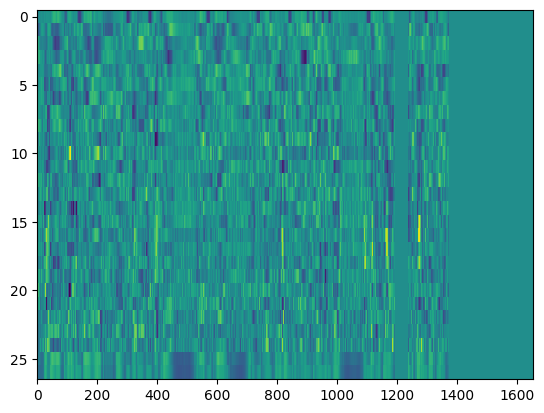

In [13]:
import matplotlib.pyplot as plt

for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    # Plots train data with its augmentations
    plt.imshow(x[0].T, interpolation='nearest', aspect='auto', cmap='viridis')
    plt.show()
    break

# NETWORK: Pyramid Bi-LSTM (pBLSTM)

# Encoder

In [14]:
class Resnet34ResidualBlock1d(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=3, padding=1):
        super(Resnet34ResidualBlock1d, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(True)
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(out_channels, out_channels, kernel_size, 1, padding, bias=False),
            nn.BatchNorm1d(out_channels)
        )
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        residual = x
        x = self.cnn1(x)
        x = self.cnn2(x)
        x += self.shortcut(residual)
        x = nn.ReLU(True)(x)
        return x

In [15]:
class pBLSTM(torch.nn.Module):
    '''
    Pyramidal BiLSTM
    Read the writeup/paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed (Unpack it)
    2. Reduce the input length dimension by concatenating feature dimension
        (Tip: Write down the shapes and understand)
        (i) How should  you deal with odd/even length input?
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''

    def __init__(self, input_size, hidden_size, n_lstm=1):
        super(pBLSTM, self).__init__()

        self.ld = torchnlp.nn.LockedDropout(p=config['dropout_p'])

        self.ln = nn.LayerNorm(input_size * 2, eps=1e-06)

        self.blstm = nn.LSTM(input_size=input_size * 2, hidden_size=hidden_size, num_layers=n_lstm, bidirectional=True,
                             batch_first=True)

    def forward(self, x_packed):  # x_packed is a PackedSequence

        # Pad Packed Sequence
        x, x_lens = pad_packed_sequence(x_packed, batch_first=True, padding_value=0.0)

        x, x_lens = self.trunc_reshape(x, x_lens)

        x = torch.permute(x, (1, 0, 2))
        x = self.ld(x)
        x = self.ln(x)
        x = torch.permute(x, (1, 0, 2))

        # Pack Padded Sequence.
        x = pack_padded_sequence(x, lengths=x_lens, batch_first=True, enforce_sorted=False)

        # Pass the sequence through bLSTM
        x, _ = self.blstm(x)

        return x

    def trunc_reshape(self, x, x_lens):
        if x.size(dim=1) % 2 == 1:
            x = x[:, :-1, :]
        x = x.reshape(x.shape[0], x.shape[1] // 2, x.shape[2] * 2)
        x_lens //= 2
        return x, x_lens

In [16]:
class Encoder(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''

    def __init__(self, input_size=27, encoder_hidden_size=256):
        super(Encoder, self).__init__()

        self.embedding_stride = 1
        self.embedding_kernel_size = 3
        self.embedding_padding = 1

        self.embedding = nn.Sequential(
            PermuteBlock(),
            Resnet34ResidualBlock1d(in_channels=input_size, out_channels=1024, stride=self.embedding_stride,
                                    kernel_size=self.embedding_kernel_size, padding=self.embedding_padding),
            PermuteBlock(),
        )

        self.pBLSTMs = nn.Sequential(
            pBLSTM(input_size=1024, hidden_size=encoder_hidden_size, n_lstm=2),
            pBLSTM(input_size=encoder_hidden_size * 2, hidden_size=encoder_hidden_size, n_lstm=2),
        )

    def forward(self, x, x_lens):
        # Call the embedding layer
        x = self.embedding(x)
        x_lens = (x_lens - self.embedding_kernel_size + 2 * self.embedding_padding) // self.embedding_stride

        # Pack Padded Sequence
        x = pack_padded_sequence(x, lengths=x_lens, batch_first=True, enforce_sorted=False)

        # Pass Sequence through the pyramidal Bi-LSTM layer
        x = self.pBLSTMs(x)

        # Pad Packed Sequence
        encoder_outputs, encoder_lens = pad_packed_sequence(x, batch_first=True, padding_value=0.0)

        return encoder_outputs, encoder_lens

# Decoder

In [17]:
class DecoderLinear(torch.nn.Module):

    def __init__(self, input_size, output_size, last_layer=False):
        super(DecoderLinear, self).__init__()

        if last_layer:
            self.model = torch.nn.Sequential(
                PermuteBlock(),
                nn.BatchNorm1d(input_size),
                PermuteBlock(),
                nn.Linear(input_size, output_size),
            )
        else:
            self.model = torch.nn.Sequential(
                PermuteBlock(),
                nn.BatchNorm1d(input_size),
                PermuteBlock(),
                nn.Linear(input_size, output_size),
                nn.GELU(),
                nn.Dropout(p=config['dropout_p']),
            )

    def forward(self, x):
        out = self.model(x)
        return out

In [18]:
class Decoder(torch.nn.Module):

    def __init__(self, embed_size=256 * 2, output_size=len(LABELS)):
        super().__init__()

        self.mlp = torch.nn.Sequential(
            DecoderLinear(input_size=embed_size, output_size=embed_size // 2),
            DecoderLinear(input_size=embed_size // 2, output_size=embed_size // 4),
            DecoderLinear(input_size=embed_size // 4, output_size=output_size, last_layer=True),
        )

        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, encoder_out):
        out = self.mlp(encoder_out)
        out = self.softmax(out)
        return out

In [19]:
class ASRModel(torch.nn.Module):

    def __init__(self, input_size, embed_size=256, output_size=len(LABELS)):
        super().__init__()
        self.encoder = Encoder(input_size=input_size, encoder_hidden_size=embed_size)
        self.decoder = Decoder(embed_size=embed_size * 2, output_size=output_size)

    def forward(self, x, lengths_x):
        encoder_out, encoder_lens = self.encoder(x, lengths_x)
        decoder_out = self.decoder(encoder_out)

        return decoder_out, encoder_lens

## INIT ASR

In [20]:
gc.collect()
torch.cuda.empty_cache()
model = ASRModel(
    input_size=27,
    embed_size=656,
    output_size=len(LABELS)
).to(device)
print(model)
summary(model)

ASRModel(
  (encoder): Encoder(
    (embedding): Sequential(
      (0): PermuteBlock()
      (1): Resnet34ResidualBlock1d(
        (cnn1): Sequential(
          (0): Conv1d(27, 1024, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (cnn2): Sequential(
          (0): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (shortcut): Sequential(
          (0): Conv1d(27, 1024, kernel_size=(1,), stride=(1,), bias=False)
          (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): PermuteBlock()
    )
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (ld): LockedDropout(p=0.25)
        (ln): LayerNorm((2048,), eps=1e-06, elementwise_a

Layer (type:depth-idx)                        Param #
ASRModel                                      --
├─Encoder: 1-1                                --
│    └─Sequential: 2-1                        --
│    │    └─PermuteBlock: 3-1                 --
│    │    └─Resnet34ResidualBlock1d: 3-2      3,262,464
│    │    └─PermuteBlock: 3-3                 --
│    └─Sequential: 2-2                        --
│    │    └─pBLSTM: 3-4                       24,543,744
│    │    └─pBLSTM: 3-5                       27,567,744
├─Decoder: 1-2                                --
│    └─Sequential: 2-3                        --
│    │    └─DecoderLinear: 3-6                863,952
│    │    └─DecoderLinear: 3-7                216,808
│    │    └─DecoderLinear: 3-8                14,145
│    └─LogSoftmax: 2-4                        --
Total params: 56,468,857
Trainable params: 56,468,857
Non-trainable params: 0

In [21]:
# del model
gc.collect()
torch.cuda.empty_cache()

# Training Config

In [22]:
criterion = nn.CTCLoss(blank=0, zero_infinity=False)
# CTC Loss: https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html
# Refer to the handout for hints

optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['adamw_weight_decay'])

# Declare the decoder. Use the CTC Beam Decoder to decode phonemes
decoder = CTCBeamDecoder(LABELS, log_probs_input=True, **config['ctc_decoder_train'])

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, **config['CA_lr_params'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **config['rlrop_params'])

# Mixed Precision, if you need it
scaler = torch.cuda.amp.GradScaler()

In [ ]:
# del criterion, optimizer, decoder, scheduler

## Decode Prediction

In [23]:
npLABELS = np.asarray(LABELS)


def decode_prediction(output, output_lens, decoder, PHONEME_MAP=npLABELS):
    beam_results, beam_scores, timesteps, output_lens = decoder.decode(output,
                                                                       seq_lens=output_lens)  #lengths - list of lengths

    pred_strings = []

    for i in range(output_lens.shape[0]):
        top_beam = beam_results[i][0][:output_lens[i][0]].numpy()
        pred_strings.append(''.join(PHONEME_MAP[top_beam]))

    return pred_strings


def calculate_levenshtein(output, label, output_lens, label_lens, decoder,
                          PHONEME_MAP=npLABELS):  # y - sequence of integers

    dist = 0
    batch_size = label.shape[0]

    pred_strings = decode_prediction(output, output_lens, decoder, PHONEME_MAP)

    for i in range(batch_size):
        pred_string = pred_strings[i]
        label_string = ''.join(PHONEME_MAP[label.cpu()[i, :label_lens[i]].numpy()])
        # print("P = {}; L = {}".format(pred_string, label_string))
        dist += Levenshtein.distance(pred_string, label_string)

    dist /= batch_size
    return dist

In [24]:
# test code to check shapes

model.eval()
for i, data in enumerate(val_loader, 0):
    x, y, lx, ly = data
    print(x.shape)
    print(lx.shape)
    x, y = x.to(device), y.to(device)
    h, lh = model(x, lx)
    print(h.shape)
    h = torch.permute(h, (1, 0, 2))
    print(h.shape, y.shape)
    loss = criterion(h, y, lh, ly)
    print(loss)

    h = torch.permute(h, (1, 0, 2))
    print(calculate_levenshtein(h, y, lh, ly, decoder, npLABELS))

    break

torch.Size([32, 2936, 27])
torch.Size([32])
torch.Size([32, 733, 41])
torch.Size([733, 32, 41]) torch.Size([32, 265])
tensor(7.6047, device='cuda:0', grad_fn=<MeanBackward0>)
65.4375


## wandb

You will need to fetch your api key from wandb.ai

In [ ]:
import wandb

wandb.login(key="<api>")

In [ ]:
run = wandb.init(
    name="v3090-tc460-pb2.2_resume+config_change+augment",  ## Wandb creates random run names if you skip this field
    reinit=True,  ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project="hw3p2-ablations",  ### Project should be created in your wandb account
    config=config  ### Wandb Config for your run
)

# Train Functions

In [ ]:
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    total_loss = 0

    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        x, y, lx, ly = data
        x, y = x.to(device), y.to(device)

        with torch.cuda.amp.autocast():
            h, lh = model(x, lx)
            h = torch.permute(h, (1, 0, 2))
            loss = criterion(h.to(torch.float64), y, lh, ly)

        total_loss += loss.item()

        batch_bar.set_postfix(
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            lr="{:.06f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update()  # Update tqdm bar

        # Another couple things you need for FP16. 
        scaler.scale(loss).backward()  # This is a replacement for loss.backward()
        scaler.step(optimizer)  # This is a replacement for optimizer.step()
        scaler.update()  # This is something added just for FP16

        del x, y, lx, ly, h, lh, loss
        torch.cuda.empty_cache()

    batch_bar.close()  # You need this to close the tqdm bar

    return total_loss / len(train_loader)


def validate_model(model, val_loader, decoder, phoneme_map=LABELS):
    model.eval()
    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    total_loss = 0
    vdist = 0

    for i, data in enumerate(val_loader):
        x, y, lx, ly = data
        x, y = x.to(device), y.to(device)

        with torch.inference_mode():
            h, lh = model(x, lx)
            h = torch.permute(h, (1, 0, 2))
            loss = criterion(h, y, lh, ly)

        total_loss += float(loss)
        vdist += calculate_levenshtein(torch.permute(h, (1, 0, 2)), y, lh, ly, decoder, phoneme_map)

        batch_bar.set_postfix(loss="{:.04f}".format(float(total_loss / (i + 1))),
                              dist="{:.04f}".format(float(vdist / (i + 1))))

        batch_bar.update()

        del x, y, lx, ly, h, lh, loss
        torch.cuda.empty_cache()

    batch_bar.close()
    total_loss = total_loss / len(val_loader)
    val_dist = vdist / len(val_loader)
    return total_loss, val_dist

### Training Setup

In [25]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict': model.state_dict(),
         'optimizer_state_dict': optimizer.state_dict(),
         'scheduler_state_dict': scheduler.state_dict(),
         metric[0]: metric[1],
         'epoch': epoch},
        path
    )


def load_model(path, model, metric='valid_dist', optimizer=None, scheduler=None):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    epoch = checkpoint['epoch']
    metric = checkpoint[metric]

    return [model, optimizer, scheduler, epoch, metric]

In [26]:
# This is for checkpointing, if you're doing it over multiple sessions

last_epoch_completed = 0
start = last_epoch_completed
end = config["epochs"]
best_lev_dist = float("inf")  # if you're restarting from some checkpoint, use what you saw there.
epoch_model_path = './checkpoint_epoch.pth'
best_model_path = './checkpoint_best.pth'

In [39]:
model, _, _, _, best_lev_dist = load_model('./checkpoint_epoch_fin.pth', model, 'valid_dist')
summary(model)

Layer (type:depth-idx)                        Param #
ASRModel                                      --
├─Encoder: 1-1                                --
│    └─Sequential: 2-1                        --
│    │    └─PermuteBlock: 3-1                 --
│    │    └─Resnet34ResidualBlock1d: 3-2      3,262,464
│    │    └─PermuteBlock: 3-3                 --
│    └─Sequential: 2-2                        --
│    │    └─pBLSTM: 3-4                       24,543,744
│    │    └─pBLSTM: 3-5                       27,567,744
├─Decoder: 1-2                                --
│    └─Sequential: 2-3                        --
│    │    └─DecoderLinear: 3-6                863,952
│    │    └─DecoderLinear: 3-7                216,808
│    │    └─DecoderLinear: 3-8                14,145
│    └─LogSoftmax: 2-4                        --
Total params: 56,468,857
Trainable params: 56,468,857
Non-trainable params: 0

In [38]:
print(config)
torch.cuda.empty_cache()
gc.collect()

{'batch_size': 32, 'epochs': 500, 'lr': 0.002, 'ctc_decoder_train': {'num_processes': 4, 'beam_width': 8}, 'ctc_decoder_test': {'num_processes': 4, 'beam_width': 50}, 'rlrop_params': {'factor': 0.75, 'patience': 4, 'threshold': 0.001, 'threshold_mode': 'rel', 'cooldown': 2}, 'CA_lr_params': {'T_max': 8, 'eta_min': 1e-06}, 'dropout_p': 0.25, 'adamw_weight_decay': 0.01, 'time_mask_maxl': 100, 'time_mask_p': 0.9, 'freq_mask_maxl': 5, 'num_workers_train': 6, 'num_workers_val': 2, 'num_workers_test': 2}


9

In [ ]:
torch.cuda.empty_cache()
gc.collect()

torch.autograd.set_detect_anomaly(False)

for epoch in range(0, config['epochs']):

    print("\nEpoch: {}/{}".format(epoch + 1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss = train_model(model, train_loader, criterion, optimizer)

    torch.cuda.empty_cache()

    w0grad = list(model.named_parameters())[0][1].grad.data[0][0][0].item()

    print("Epoch {}/{}: Train Loss {:.04f}\t Learning Rate {:.04f}\t w0grad = {}".format(
        epoch + 1,
        config['epochs'],
        train_loss,
        curr_lr,
        w0grad))

    valid_loss, valid_dist = validate_model(model, val_loader, decoder, phoneme_map=npLABELS)
    scheduler.step(valid_loss)

    torch.cuda.empty_cache()

    print("\tVal Dist {:.04f}\t Val Loss {:.04f}".format(valid_dist, valid_loss))

    wandb.log({
        'train_loss': train_loss,
        'valid_dist': valid_dist,
        'valid_loss': valid_loss,
        'lr': curr_lr,
        'w0grad': w0grad,
    })

    save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, epoch_model_path)
    wandb.save(epoch_model_path)
    print("Saved epoch model")

    if valid_dist <= best_lev_dist:
        best_lev_dist = valid_dist
        save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, best_model_path)
        wandb.save(best_model_path)
        print("Saved best model")

In [ ]:
run.finish()

# Generate Predictions and Submit to Kaggle

In [43]:
test_decoder = CTCBeamDecoder(LABELS, log_probs_input=True, **config['ctc_decoder_test'])

results = []

model.eval()
print("Testing")
for data in tqdm(test_loader):

    x, lx = data
    x = x.reshape(x.shape, 1).to(device)

    with torch.no_grad():
        h, lh = model(x, lx)
    prediction_strings = decode_prediction(h, lh, test_decoder, PHONEME_MAP=npLABELS)

    for pred in prediction_strings:
        results.append(''.join(pred))

    del x, lx, h, lh
    torch.cuda.empty_cache()

Testing


100%|██████████| 82/82 [01:28<00:00,  1.07s/it]


In [44]:
data_dir = './11-785-s23-hw3p2/test-clean/random_submission.csv'
df = pd.read_csv(data_dir)
df.label = results
df.to_csv('submission.csv', index=False)

!kaggle competitions submit -c 11-785-s23-hw3p2 -f submission.csv -m "I made it!"

100%|█████████████████████████████████████████| 210k/210k [00:00<00:00, 301kB/s]
Successfully submitted to Automatic Speech Recognition (ASR)